## General Imports

In [38]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

from scipy import stats

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error, accuracy_score, make_scorer, precision_score, recall_score, f1_score

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer

from sklearn.decomposition import PCA

mpl.rc(group='figure', figsize=(10,8))
plt.style.use('seaborn')

from warnings import filterwarnings
filterwarnings('ignore')

## Take Dataset

In [39]:
filepath = '../data/'
train = pd.read_csv(filepath + 'train.csv')
test = pd.read_csv(filepath + 'test.csv')

T = test.copy()

train.replace(to_replace='correct', value=1, inplace=True)
train.replace(to_replace='incorrect', value=0, inplace=True)

X = train.iloc[:, 1:-1]
Y = train['label']

# TODO: replace lat lon with calculated distance from google maps api
# https://maps.googleapis.com/maps/api/distancematrix/json?units=imperial&origins=6.86252,79.8993&destinations=6.9033,79.8783&key=API_KEY

In [40]:
X

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,10.5,834,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32
1,10.5,791,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85
2,10.5,1087,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64
3,10.5,598,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30
4,NaN,1020,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39
...,...,...,...,...,...,...,...,...,...,...,...,...
17171,10.5,838,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26
17172,10.5,2151,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23
17173,10.5,263,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20
17174,10.5,858,115.0,0.0000,317.0,1/31/2020 23:39,1/31/2020 23:53,6.94540,79.8768,6.93574,79.9010,133.31


Class 0: 1681
Class 1: 15495
Proportion: 0.11 : 1


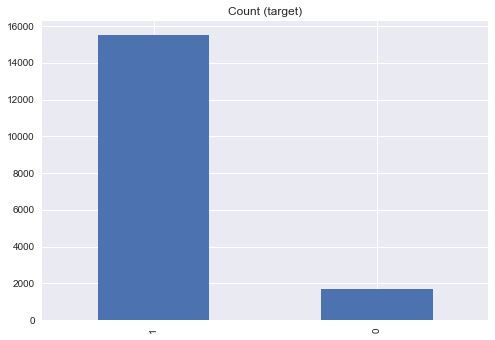

In [41]:
target_count = train.label.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Random under-sampling:
1    1681
0    1681
Name: label, dtype: int64


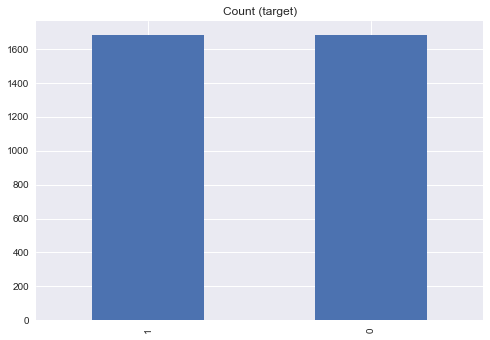

In [42]:
# Divide by class
df_class_0 = train[train['label'] == 0]
df_class_1 = train[train['label'] == 1]

#Random under-sampling
df_class_1_under = df_class_1.sample(target_count[0])
df_test_under = pd.concat([df_class_1_under, df_class_0], axis=0)

print('Random under-sampling:')
print(df_test_under.label.value_counts())

df_test_under.label.value_counts().plot(kind='bar', title='Count (target)')

In [43]:
X = df_test_under.iloc[:, 1:-1]
Y = df_test_under['label']

## Filling Missing values

#### duration filled in excel

In [44]:
X['additional_fare'].fillna(10.5, inplace=True)
X['meter_waiting'].fillna(X['meter_waiting'].mean(), inplace=True)
X['meter_waiting_fare'].fillna(X['meter_waiting_fare'].mean(), inplace=True)
X['meter_waiting_till_pickup'].fillna(X['meter_waiting_till_pickup'].mean(), inplace=True)
X['fare'].fillna(X['additional_fare']+X['meter_waiting_fare'], inplace=True)

In [45]:
X

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
1815,10.5,1117,666.000000,38.548564,102.000000,11/10/2019 15:44,11/10/2019 16:02,6.98773,79.8912,6.99110,79.8958,178.65000
3369,10.5,1635,90.000000,0.000000,102.000000,11/20/2019 16:25,11/20/2019 16:52,6.86923,79.8810,6.87136,79.9557,358.71000
1755,10.5,1499,290.000000,16.907000,231.000000,11/10/2019 9:06,11/10/2019 9:31,6.88271,79.9454,6.91764,79.8548,470.60000
391,10.5,1186,130.000000,7.532599,88.000000,11/3/2019 12:45,11/3/2019 13:05,7.28980,80.6341,7.24951,80.6340,254.95000
12954,10.5,955,112.000000,0.000000,591.000000,1/9/2020 20:20,1/9/2020 20:36,7.23884,79.8594,7.20415,79.8514,210.25000
...,...,...,...,...,...,...,...,...,...,...,...,...
17123,10.5,4380,1795.384279,96.951310,133.735184,1/31/2020 16:46,1/31/2020 17:59,6.87969,79.8597,6.97458,79.9380,107.45131
17130,40.5,4310,1314.000000,75.949200,469.000000,1/31/2020 17:22,1/31/2020 18:34,6.91819,79.8627,6.83700,79.8947,902.02000
17131,40.5,913,445.000000,0.000000,47.000000,1/31/2020 17:39,1/31/2020 17:54,7.29842,80.6363,7.30808,80.6399,534.00000
17150,10.5,3660,1795.384279,96.951310,133.735184,1/31/2020 19:42,1/31/2020 20:43,6.93046,79.8903,6.91713,79.8910,107.45131


## Format datetime values

In [46]:
# Removing datetime columns for now
# TODO: encode in pickup_year,pickup_month,pickup_date,pickup_hour,pickup_min etc

X.drop(['pickup_time','drop_time'], axis=1, inplace=True)
T.drop(['tripid', 'pickup_time','drop_time'], axis=1, inplace=True)

## Test Train Split

In [47]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Normalize

In [48]:
# normalizer = Normalizer()
# normalizer.fit(X_train)

# X_train = normalizer.transform(X_train)
# X_test = normalizer.transform(X_test)

## PCA

In [49]:
pca = PCA(10)
pca.fit(X_train)

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

## Cross-val

In [50]:
model = RandomForestClassifier(n_jobs=5, random_state=0)

scores = cross_val_score(model, X, Y, cv=5, scoring='f1_macro')
scores

array([0.8125199 , 0.80950022, 0.83852911, 0.84654643, 0.82732589])

## Model

In [51]:
model = RandomForestClassifier(n_jobs=5, random_state=0)
model.fit(X_train, Y_train)
Y_predict = model.predict(X_test)
print("Accuracy: " , accuracy_score(Y_test, Y_predict))
print("F1: " , f1_score(Y_test, Y_predict))

Accuracy:  0.849925705794948
F1:  0.8595271210013908


## For all data

In [11]:
Y

0        1
1        1
2        1
3        1
4        1
        ..
17171    1
17172    1
17173    1
17174    1
17175    1
Name: label, Length: 17176, dtype: int64

In [12]:
pca = PCA(10)
pca.fit(X)

X = pca.transform(X)
T = pca.transform(T)

model = RandomForestClassifier(n_jobs=5, random_state=1)
model.fit(X, Y)
T_Predict = model.predict(T)

T_Predict

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

## Submission

In [52]:
T = pca.transform(T)

T_Predict = model.predict(T)

T_Predict

name = "randomforest_pca10_jobs5_state1_sampled"

date = datetime.now().strftime('%m-%d-%H_%M_%S')
file = open("../submissions/" + name + "_" + date + ".csv", "w+")

submit = pd.DataFrame()
submit["tripid"] = test["tripid"]
submit["prediction"] = T_Predict

submit

,tripid,prediction
0,213284604,1
1,213286352,0
2,213293973,1
3,213294622,1
4,213298687,1
...,...,...
8571,222856243,1
8572,222857785,1
8573,222858416,1
8574,222858691,1


In [53]:
submit.to_csv(file, header=True, index=False, line_terminator='\n')
file.flush()